In [ ]:
!pip install pydicom matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.2 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = '/content/UOA0000101.zip'
extract_path = '/content/annotation/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)

Files extracted to: /content/annotation/


In [ ]:
# List the contents of the extracted directory
for root, dirs, files in os.walk(extract_path):
    for file in files:
        print(f"File: {file} - Path: {os.path.join(root, file)}")

File: IM-0041-0025.dcm - Path: /content/annotation/UOA0000101/IM-0041-0025.dcm
File: IM-0046-0011.dcm - Path: /content/annotation/UOA0000101/IM-0046-0011.dcm
File: IM-0005-0001.dcm - Path: /content/annotation/UOA0000101/IM-0005-0001.dcm
File: IM-0002-0020.dcm - Path: /content/annotation/UOA0000101/IM-0002-0020.dcm
File: IM-0013-0009.dcm - Path: /content/annotation/UOA0000101/IM-0013-0009.dcm
File: IM-0006-0014.dcm - Path: /content/annotation/UOA0000101/IM-0006-0014.dcm
File: IM-0029-0018.dcm - Path: /content/annotation/UOA0000101/IM-0029-0018.dcm
File: IM-0026-0024.dcm - Path: /content/annotation/UOA0000101/IM-0026-0024.dcm
File: IM-0036-0029.dcm - Path: /content/annotation/UOA0000101/IM-0036-0029.dcm
File: IM-0032-0017.dcm - Path: /content/annotation/UOA0000101/IM-0032-0017.dcm
File: IM-0020-0032.dcm - Path: /content/annotation/UOA0000101/IM-0020-0032.dcm
File: IM-0004-0006.dcm - Path: /content/annotation/UOA0000101/IM-0004-0006.dcm
File: IM-0021-0025.dcm - Path: /content/annotation/U

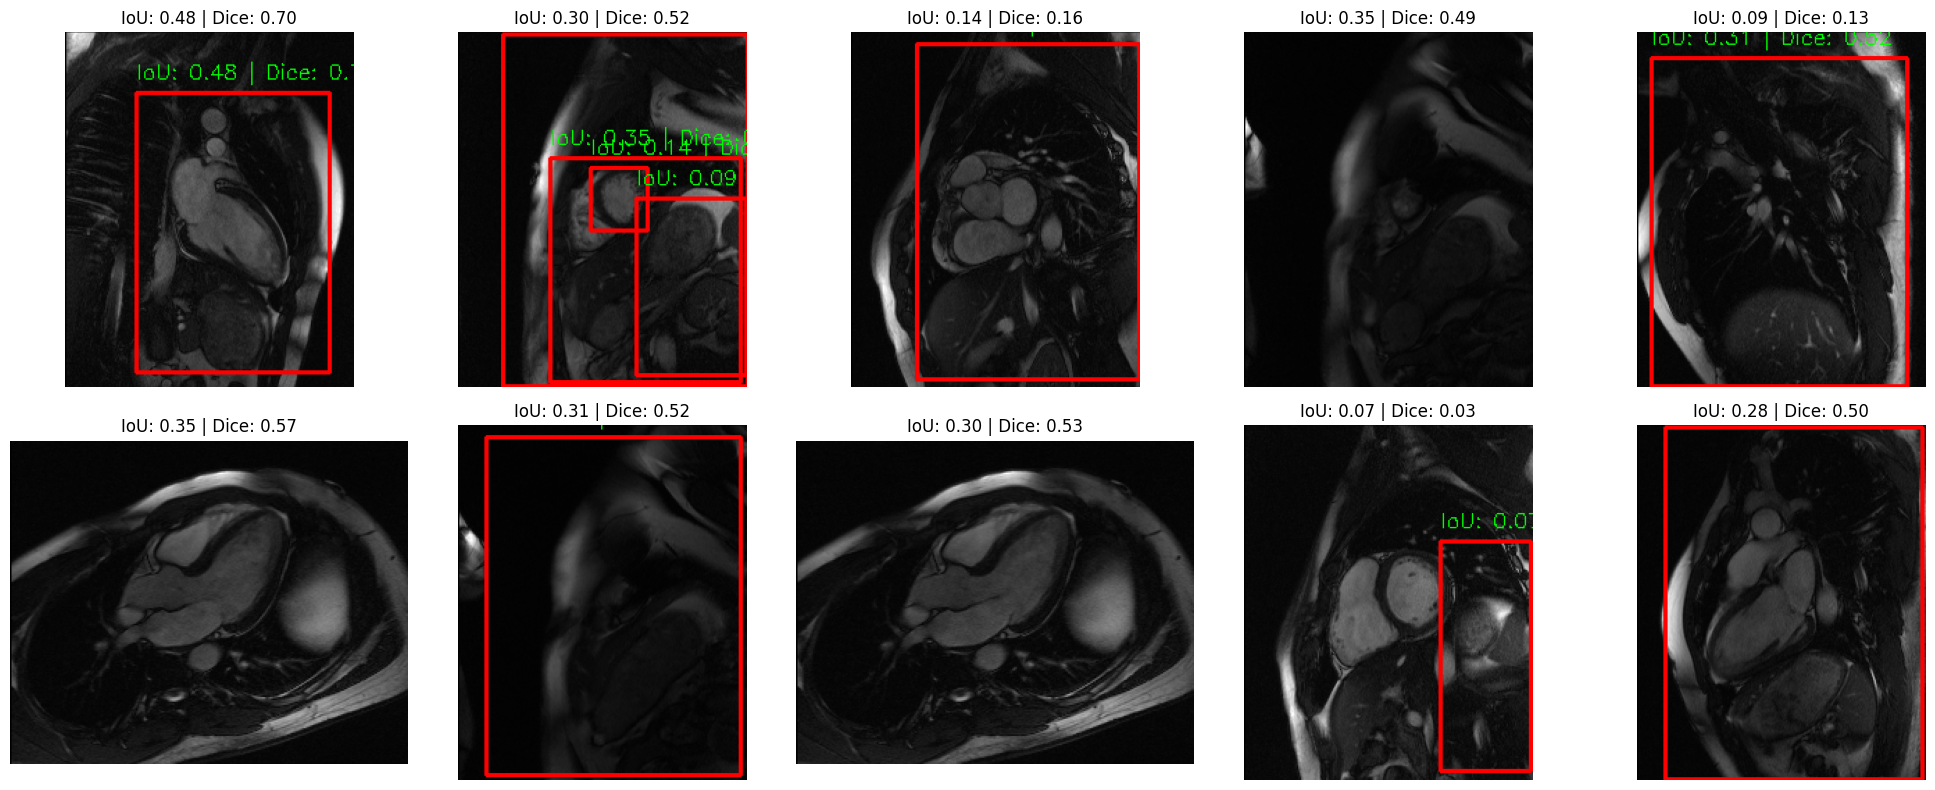

Average IoU across all images: 0.27
Average Dice coefficient across all images: 0.42


In [ ]:
import os
import pydicom
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Load the Mask R-CNN model pre-trained on COCO dataset
model = maskrcnn_resnet50_fpn(weights="COCO_V1")
model.eval()

# Function to load and preprocess DICOM image
def load_dicom_image(file_path):
    dicom = pydicom.dcmread(file_path)
    image = dicom.pixel_array
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image = np.uint8(image)
    return image, dicom

# Function to calculate Intersection over Union (IoU)
def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# Function to calculate Dice coefficient
def dice_coefficient(pred_mask, gt_mask):
    intersection = np.sum(pred_mask * gt_mask)
    total_pixels = np.sum(pred_mask) + np.sum(gt_mask)
    dice = (2 * intersection) / total_pixels if total_pixels > 0 else 0
    return dice

# List of specific DICOM file paths
dicom_files = [
    "/content/annotation/UOA0000101/IM-0038-0025.dcm",
    "/content/annotation/UOA0000101/IM-0023-0023.dcm",
    "/content/annotation/UOA0000101/IM-0011-0029.dcm",
 "/content/annotation/UOA0000101/IM-0027-0031.dcm",
 "/content/annotation/UOA0000101/IM-0001-0019.dcm",
 "/content/annotation/UOA0000101/IM-0034-0024.dcm",
 "/content/annotation/UOA0000101/IM-0028-0030.dcm",
     "/content/annotation/UOA0000101/IM-0034-0027.dcm",
 "/content/annotation/UOA0000101/IM-0015-0031.dcm",
 "/content/annotation/UOA0000101/IM-0036-0004.dcm",
]

# Display DICOM images with bounding boxes, IoU, and Dice score
iou_scores, dice_scores = [], []
images_with_annotations = []

for file_path in dicom_files:
    image, dicom_metadata = load_dicom_image(file_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    # Placeholder ground truth bounding box (replace with actual ground truth if available)
    ground_truth_bbox = [int(0.25 * image.shape[1]), int(0.25 * image.shape[0]),
                         int(0.75 * image.shape[1]), int(0.75 * image.shape[0])]

    # Model predictions
    input_image = F.to_tensor(image_rgb).unsqueeze(0)
    with torch.no_grad():
        predictions = model(input_image)

    pred_boxes = predictions[0]['boxes'].cpu().numpy().astype(int)
    pred_masks = predictions[0]['masks'].cpu().numpy() > 0.5  # Thresholding mask

    for i, bbox in enumerate(pred_boxes):
        score = predictions[0]['scores'][i].item()
        if score < 0.5:
            continue

        # IoU and Dice Score calculations
        iou = calculate_iou(bbox, ground_truth_bbox)
        pred_mask = pred_masks[i, 0]  # Get the i-th predicted mask (binary mask)

        # Create a ground truth mask
        ground_truth_mask = np.zeros_like(pred_mask, dtype=np.uint8)
        cv2.rectangle(ground_truth_mask, (ground_truth_bbox[0], ground_truth_bbox[1]),
                      (ground_truth_bbox[2], ground_truth_bbox[3]), 1, -1)
        dice = dice_coefficient(pred_mask, ground_truth_mask)

        # Store scores
        iou_scores.append(iou)
        dice_scores.append(dice)

        # Draw bounding box, IoU, and Dice on the image
        cv2.rectangle(image_rgb, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)  # Red box
        label = f"IoU: {iou:.2f} | Dice: {dice:.2f}"
        cv2.putText(image_rgb, label, (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    images_with_annotations.append(image_rgb)

# Display images in a grid (5 images per row)
num_images = len(images_with_annotations)
rows = num_images // 5 + (1 if num_images % 5 != 0 else 0)
fig, axes = plt.subplots(rows, 5, figsize=(20, rows * 4))
axes = axes.flatten()

for idx, img in enumerate(images_with_annotations):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"IoU: {iou_scores[idx]:.2f} | Dice: {dice_scores[idx]:.2f}")

# Hide any empty subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

# Calculate and print overall scores
average_iou = np.mean(iou_scores) if iou_scores else 0
average_dice = np.mean(dice_scores) if dice_scores else 0
print(f"Average IoU across all images: {average_iou:.2f}")
print(f"Average Dice coefficient across all images: {average_dice:.2f}")

In [ ]:
import pydicom

# Define the path to your DICOM file
file_path = "/content/annotation/UOA0000101/IM-0038-0025.dcm"  # Update with the path to one of your DICOM files

# Load the DICOM file
dicom_data = pydicom.dcmread(file_path)

# Print specific metadata fields
print("Patient ID:", dicom_data.PatientID)
print("Modality:", dicom_data.Modality)
print("Image Dimensions:", dicom_data.pixel_array.shape)

Patient ID: UOA0000101
Modality: MR
Image Dimensions: (256, 208)
